# Homework week 8

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

Note that this has been updated after seeing McElreath's [solutions](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework).

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

The data in week08_Monks.csv (found on the course website) are “like” and
“dislike” nominations by 18 monks living in the same monastery over three time
periods. Therefore the observed variables are counts from 0 to 3 of times monk A
nominated monk B as liked or disliked.1 Each row in the data is a pair of monks (a
dyad). The variables are:
- A: Index number for first monk in dyad
- B: Index number for second monk in dyad
- like_AB: Number of times A nominated B as liked
- like_BA: Number of times B nominated A as liked
- dislike_AB: Number of times A nominated B as disliked
- dislike_BA: Number of times B nominated A as disliked

# Q1

Use these data to estimate the amount of reciprocity in “like” nominations within dyads. You can ignore the “dislike” data for now. Use the social network example from the book to help, but you should modify it appropriately.

## Answer

The model equation will be similar. `L` will represent the number of likes given from one person to another and `T` will remain representative of a friendship tie between the pair.

The key is recognizing that there's a maximum of three, so conditions are more consistent for binomial than Poisson.

$$ L_{AB} \sim \text{Binomial}(n=3, p_{AB}) $$
$$ L_{BA} \sim \text{Binomial}(n=3, p_{BA}) $$

$$ \text{logit}(p_{AB}) \sim \alpha + T_{AB} $$
$$ \text{logit}(p_{BA}) \sim \alpha + T_{BA} $$

We can use the centered or non-centered paramaterization. I'm showing the centered form here but will implement the non-centered form down below.

$$ \begin{pmatrix} T_{AB} \\ T_{BA} \end{pmatrix} \sim \text{MVNormal}  \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix} , \begin{bmatrix} \sigma^2 & \rho\sigma \\ \rho\sigma & \sigma^2 \end{bmatrix} \right)    $$

$$ \rho \sim \text{LKJCorr}(2) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \alpha \sim \text{Normal}(0,1) $$

Here's the non-centered paramaterization equations:

(TBD)

In [8]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_monks = pd.read_csv(DATA_DIR + "week08_Monks.csv", sep=",", header=0)
print("DF shape: ", df_monks.shape)

# modify for python
df_monks['A_code'] = pd.Categorical(df_monks['A']).codes
df_monks['B_code'] = pd.Categorical(df_monks['B']).codes
df_monks.head()

DF shape:  (153, 9)


,dyad_id,A,B,like_AB,like_BA,dislike_AB,dislike_BA,A_name,B_name,A_code,B_code
0,1,1,2,0,3,0,0,ROMUL,BONAVEN,0,0
1,2,1,3,3,3,0,0,ROMUL,AMBROSE,0,1
2,3,1,4,0,0,0,0,ROMUL,BERTH,0,2
3,4,1,5,0,0,0,0,ROMUL,PETER,0,3
4,5,1,6,0,0,0,0,ROMUL,LOUIS,0,4


<IPython.core.display.Javascript object>

The first thing I noticed is that with an odd number of rows, I wasn't sure if all dyad pairs of monks may be represented, but they are.

In [5]:
N = 18
dyads = pd.DataFrame(list(itertools.combinations(range(N), 2)))
dyads

,0,1
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
148,14,16
149,14,17
150,15,16
151,15,17


<IPython.core.display.Javascript object>

In [6]:
N_dyads = len(df_monks)

<IPython.core.display.Javascript object>

The model will use the non-centered form of the equation.

In [9]:
with pm.Model() as mq1a:
    
    # non-centered paramaterization
    
    ## dyad effects
    sd_dist = pm.Exponential.dist(1.0)

    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    z = pm.Normal("z", 0.0, 1.0, shape=(2, N_dyads))
    T = pm.Deterministic("T", pm.math.dot(chol, z).T)

    # linear models
    alpha = pm.Normal("alpha", 0, 1)
    p_AB = pm.Deterministic("lambdaAB", pm.math.invlogit(alpha + T[dyads.index, 0]))
    p_BA = pm.Deterministic("lambdaBA", pm.math.invlogit(alpha + T[dyads.index, 1]))

    L_AB = pm.Binomial("L_AB", n=3, p = p_AB, observed = df_monks['like_AB'])
    L_BA = pm.Binomial("L_BA", n=3, p = p_BA, observed = df_monks['like_BA'])

    trace_mq1a = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, z, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


<IPython.core.display.Javascript object>

In [10]:
az.summary(trace_mq1a, var_names='T')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"T[0,0]",1.379,1.603,-1.065,3.838,0.027,0.019,3456.0,3456.0,3777.0,2605.0,1.0
"T[0,1]",6.007,1.694,3.297,8.407,0.030,0.022,3190.0,3057.0,3194.0,2810.0,1.0
"T[1,0]",5.933,1.556,3.459,8.161,0.027,0.020,3445.0,2954.0,3852.0,2871.0,1.0
"T[1,1]",7.753,2.345,4.272,11.244,0.039,0.031,3701.0,2870.0,4631.0,2624.0,1.0
"T[2,0]",-1.205,2.204,-4.509,2.393,0.033,0.033,4513.0,2255.0,4973.0,2972.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"T[150,1]",-1.859,2.962,-6.331,2.743,0.043,0.042,4702.0,2537.0,5289.0,3107.0,1.0
"T[151,0]",-1.239,2.198,-4.467,2.270,0.031,0.032,4940.0,2372.0,5356.0,3403.0,1.0
"T[151,1]",-1.901,2.954,-6.246,2.731,0.041,0.042,5319.0,2467.0,6396.0,2757.0,1.0
"T[152,0]",5.957,1.580,3.505,8.337,0.025,0.019,3909.0,3456.0,4192.0,2534.0,1.0


<IPython.core.display.Javascript object>

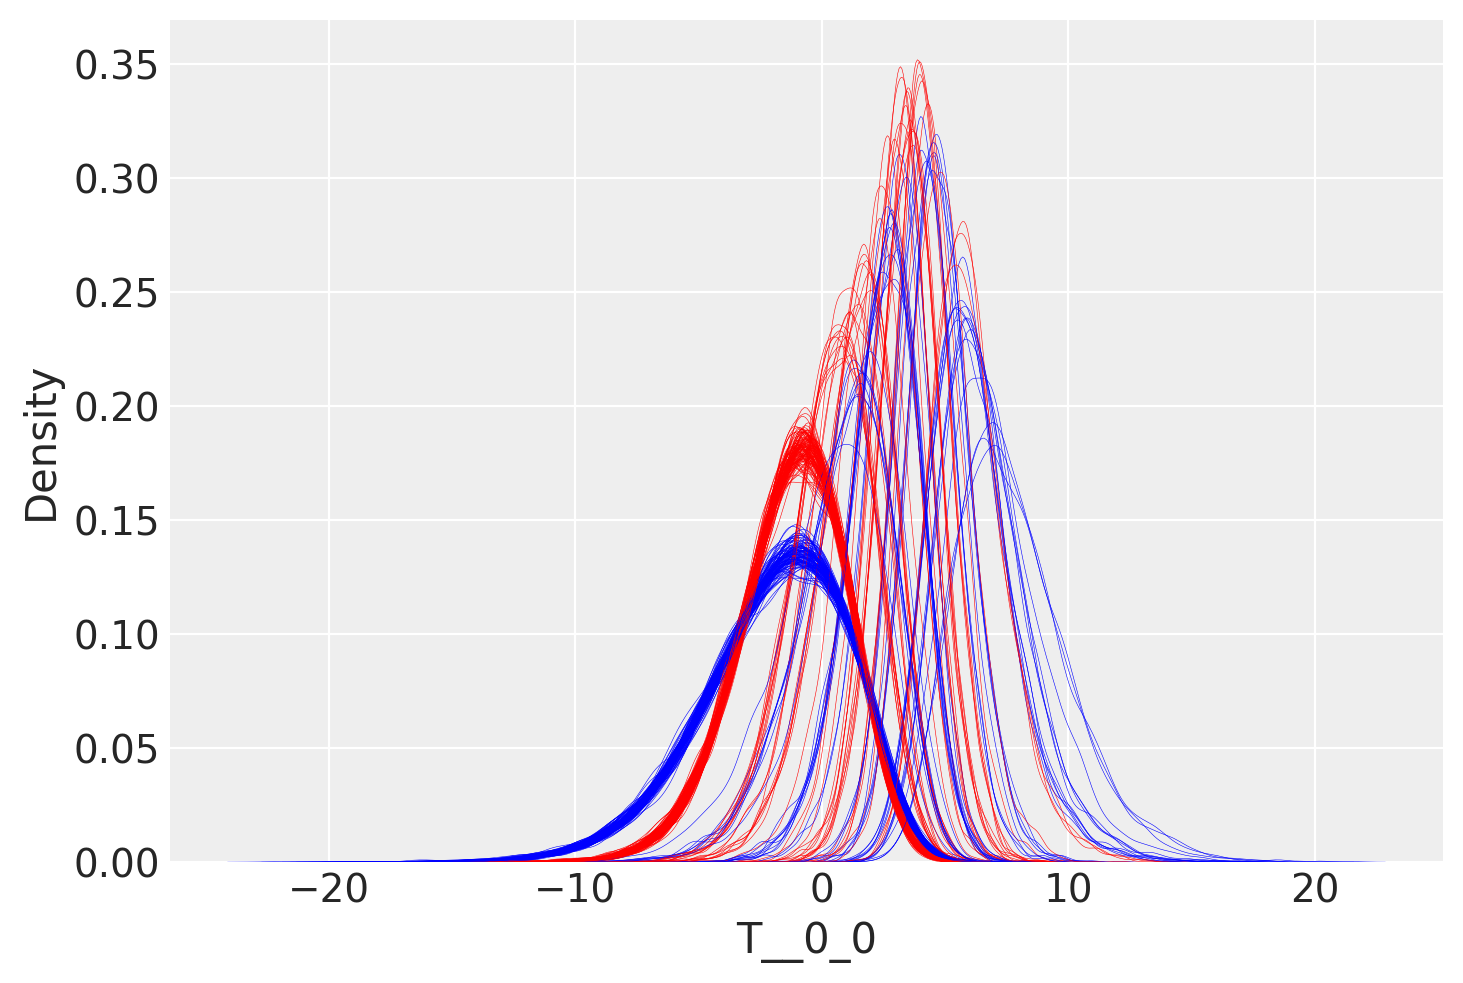

<IPython.core.display.Javascript object>

In [15]:
trace_mq1a_df = pm.trace_to_dataframe(trace_mq1a)
T_cols = [col for col in trace_mq1a_df.columns if 'T__' in col]

T0_means = list()
T1_means = list()

f, ax0 = plt.subplots()
for T_col in T_cols:
    if T_col.split('T__')[1].split('_')[1] == str(0):
        sns.kdeplot(trace_mq1a_df[T_col], ax=ax0, color='r', linewidth=0.2)
        T0_means.append(trace_mq1a_df[T_col].mean())
    if T_col.split('T__')[1].split('_')[1] == str(1):
        sns.kdeplot(trace_mq1a_df[T_col], ax=ax0, color='b', linewidth=0.2)
        T1_means.append(trace_mq1a_df[T_col].mean())

In [16]:
T_est = pd.DataFrame({"TO":T0_means, "T1":T1_means})
T_est

,TO,T1
0,1.378782,6.006714
1,5.932878,7.753414
2,-1.205326,-1.883116
3,-1.168470,-1.863416
4,-1.195641,-1.920515
...,...,...
148,-1.185560,-1.917001
149,-1.213568,-1.975833
150,-1.182514,-1.858521
151,-1.239016,-1.901448


<IPython.core.display.Javascript object>

In [17]:
# convert to adjacency matrix

y_est = np.zeros((N, N))
y_est[y_est==0] = None

for i in range(N_dyads):
    y_est[ dyads.iloc[i,0] , dyads.iloc[i,1] ] = T_est.iloc[i,0]
    y_est[ dyads.iloc[i,1] , dyads.iloc[i,0] ] = T_est.iloc[i,1]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'correlation within dyads'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'unsure if this is right')]

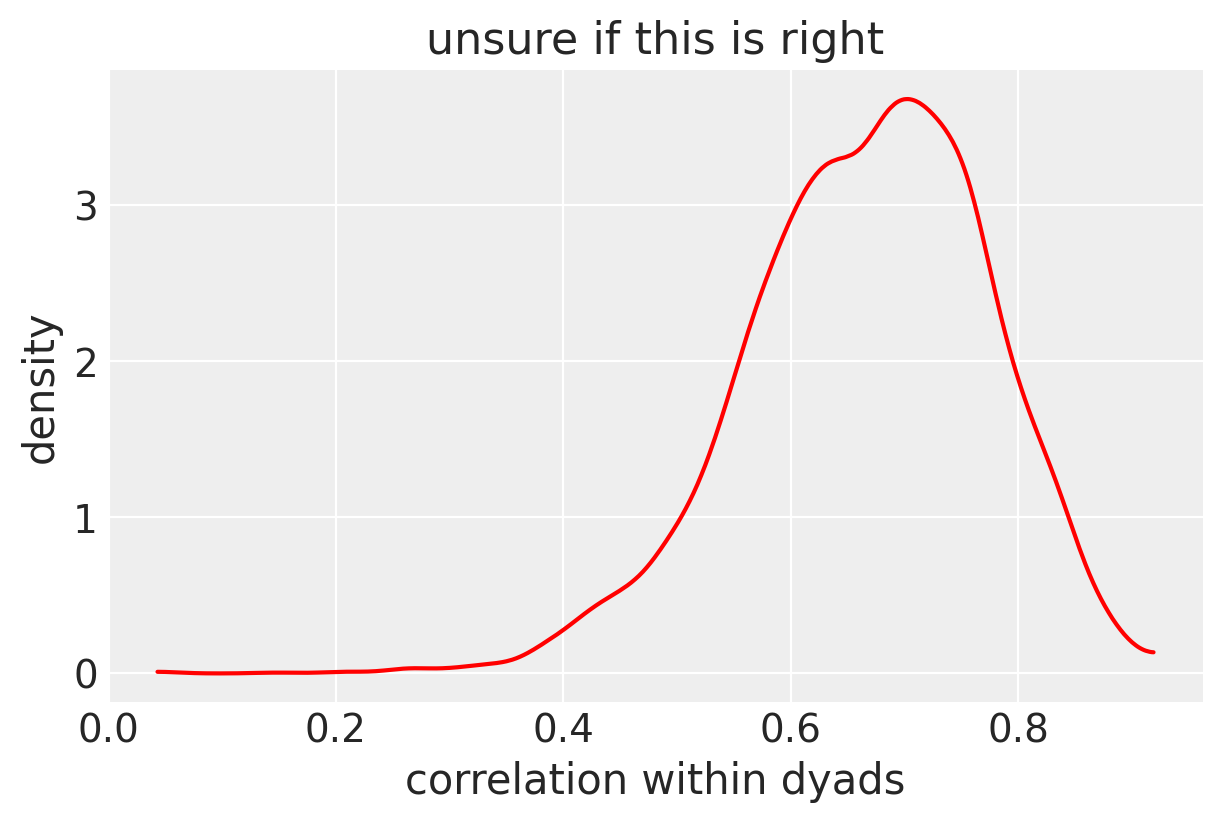

<IPython.core.display.Javascript object>

In [18]:
f, ax0 = plt.subplots(1, 1, figsize=(6, 4))
az.plot_kde(trace_mq1a_df['chol_corr__0_1'], plot_kwargs={"color": "red"}, ax=ax0)
ax0.set(xlabel='correlation within dyads', ylabel='density', title='unsure if this is right')

When comparing to the homework solutions, `Rho_T` is equivalent to `chol_corr` and `sigma_T` is equivalent to `chol_stds`, although I'm unsure why there are two.

Could be sigmas of the individual components and not its covariance.

In [22]:
az.summary(trace_mq1a, var_names=['chol_corr', 'chol_stds'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_corr[0,1]",0.665,0.107,0.516,0.845,0.003,0.002,1213.0,1202.0,1206.0,2114.0,1.0
"chol_corr[1,0]",0.665,0.107,0.516,0.845,0.003,0.002,1213.0,1202.0,1206.0,2114.0,1.0
"chol_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4219.0,3773.0,1.0
chol_stds[0],2.711,0.409,2.100,3.389,0.011,0.008,1414.0,1401.0,1435.0,2196.0,1.0
chol_stds[1],3.862,0.546,2.973,4.682,0.015,0.011,1272.0,1272.0,1283.0,2141.0,1.0


<IPython.core.display.Javascript object>

In [25]:
[print(i) for i in trace_mq1a_df.columns]

z__0_0
z__0_1
z__0_2
z__0_3
z__0_4
z__0_5
z__0_6
z__0_7
z__0_8
z__0_9
z__0_10
z__0_11
z__0_12
z__0_13
z__0_14
z__0_15
z__0_16
z__0_17
z__0_18
z__0_19
z__0_20
z__0_21
z__0_22
z__0_23
z__0_24
z__0_25
z__0_26
z__0_27
z__0_28
z__0_29
z__0_30
z__0_31
z__0_32
z__0_33
z__0_34
z__0_35
z__0_36
z__0_37
z__0_38
z__0_39
z__0_40
z__0_41
z__0_42
z__0_43
z__0_44
z__0_45
z__0_46
z__0_47
z__0_48
z__0_49
z__0_50
z__0_51
z__0_52
z__0_53
z__0_54
z__0_55
z__0_56
z__0_57
z__0_58
z__0_59
z__0_60
z__0_61
z__0_62
z__0_63
z__0_64
z__0_65
z__0_66
z__0_67
z__0_68
z__0_69
z__0_70
z__0_71
z__0_72
z__0_73
z__0_74
z__0_75
z__0_76
z__0_77
z__0_78
z__0_79
z__0_80
z__0_81
z__0_82
z__0_83
z__0_84
z__0_85
z__0_86
z__0_87
z__0_88
z__0_89
z__0_90
z__0_91
z__0_92
z__0_93
z__0_94
z__0_95
z__0_96
z__0_97
z__0_98
z__0_99
z__0_100
z__0_101
z__0_102
z__0_103
z__0_104
z__0_105
z__0_106
z__0_107
z__0_108
z__0_109
z__0_110
z__0_111
z__0_112
z__0_113
z__0_114
z__0_115
z__0_116
z__0_117
z__0_118
z__0_119
z__0_120
z__0_121
z__0_122
z__

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [41]:
df_monks.head()

,dyad_id,A,B,like_AB,like_BA,dislike_AB,dislike_BA,A_name,B_name,A_code,B_code
0,1,1,2,0,3,0,0,ROMUL,BONAVEN,0,0
1,2,1,3,3,3,0,0,ROMUL,AMBROSE,0,1
2,3,1,4,0,0,0,0,ROMUL,BERTH,0,2
3,4,1,5,0,0,0,0,ROMUL,PETER,0,3
4,5,1,6,0,0,0,0,ROMUL,LOUIS,0,4


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'A likes B'), Text(0, 0.5, 'B likes A')]

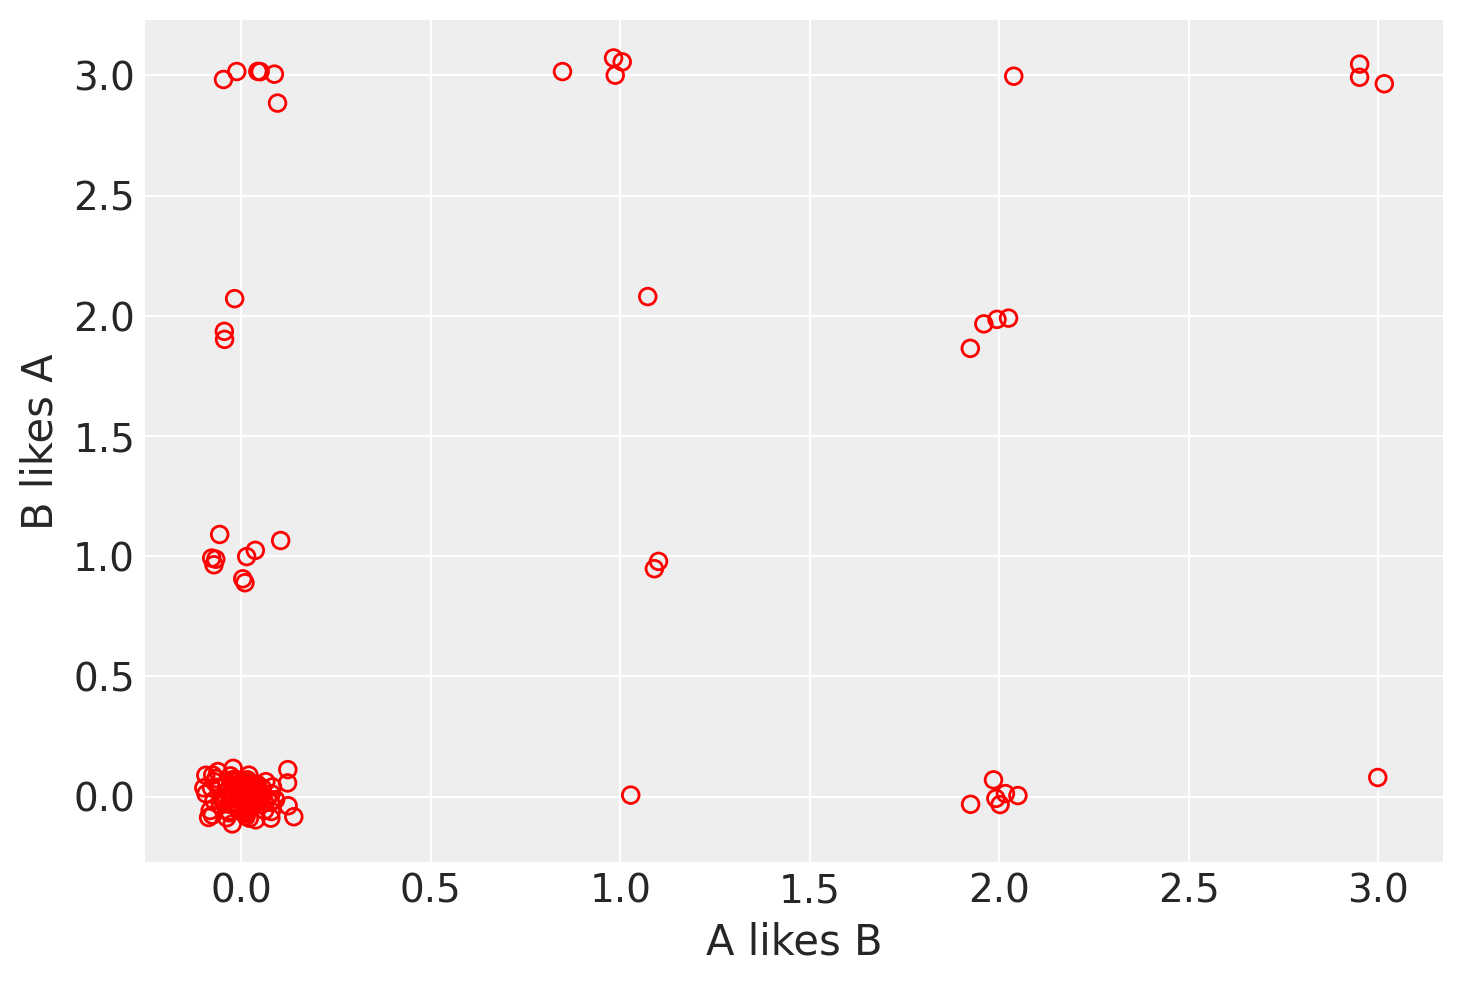

<IPython.core.display.Javascript object>

In [43]:
f, ax0 = plt.subplots()
x_jitter = np.random.normal(0, 0.05, size=N_dyads)
y_jitter = np.random.normal(0, 0.05, size=N_dyads)

ax0.scatter(df_monks['like_AB'] + x_jitter, df_monks['like_BA'] + y_jitter, facecolors='none', edgecolors='r')
ax0.set(xlabel='A likes B', ylabel='B likes A')

# Q2

Now also analyze the “dislike” nominations. Estimate the amount of reciprocity
in the “dislike” nominations and compare to the estimate from the “like” nominations.
Does “like” or “dislike” have higher reciprocity? Be sure to compute the
posterior contrast between the two estimates.

## Answer


In [44]:
df_monks

,dyad_id,A,B,like_AB,like_BA,dislike_AB,dislike_BA,A_name,B_name,A_code,B_code
0,1,1,2,0,3,0,0,ROMUL,BONAVEN,0,0
1,2,1,3,3,3,0,0,ROMUL,AMBROSE,0,1
2,3,1,4,0,0,0,0,ROMUL,BERTH,0,2
3,4,1,5,0,0,0,0,ROMUL,PETER,0,3
4,5,1,6,0,0,0,0,ROMUL,LOUIS,0,4
...,...,...,...,...,...,...,...,...,...,...,...
148,149,15,17,0,0,0,0,AMAND,ELIAS,14,15
149,150,15,18,0,0,0,0,AMAND,SIMP,14,16
150,151,16,17,0,0,0,0,BASIL,ELIAS,15,15
151,152,16,18,0,0,0,0,BASIL,SIMP,15,16


<IPython.core.display.Javascript object>

In [45]:
with pm.Model() as mq2a:
    
    # non-centered paramaterization
    
    ## dyad effects
    sd_dist = pm.Exponential.dist(1.0)

    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    z = pm.Normal("z", 0.0, 1.0, shape=(2, N_dyads))
    T = pm.Deterministic("T", pm.math.dot(chol, z).T)

    # linear models
    alpha = pm.Normal("alpha", 0, 1)
    lambdaAB = pm.Deterministic("lambdaAB", pm.math.exp(alpha + T[dyads.index, 0]))
    lambdaBA = pm.Deterministic("lambdaBA", pm.math.exp(alpha + T[dyads.index, 1]))

    DL_AB = pm.Poisson("DL_AB", mu = lambdaAB, observed = df_monks['dislike_AB'])
    DL_BA = pm.Poisson("DL_BA", mu = lambdaBA, observed = df_monks['dislike_BA'])

    trace_mq2a = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, z, chol]
INFO:pymc3:NUTS: [alpha, z, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [47]:
trace_mq2a_df = pm.trace_to_dataframe(trace_mq2a)

<IPython.core.display.Javascript object>

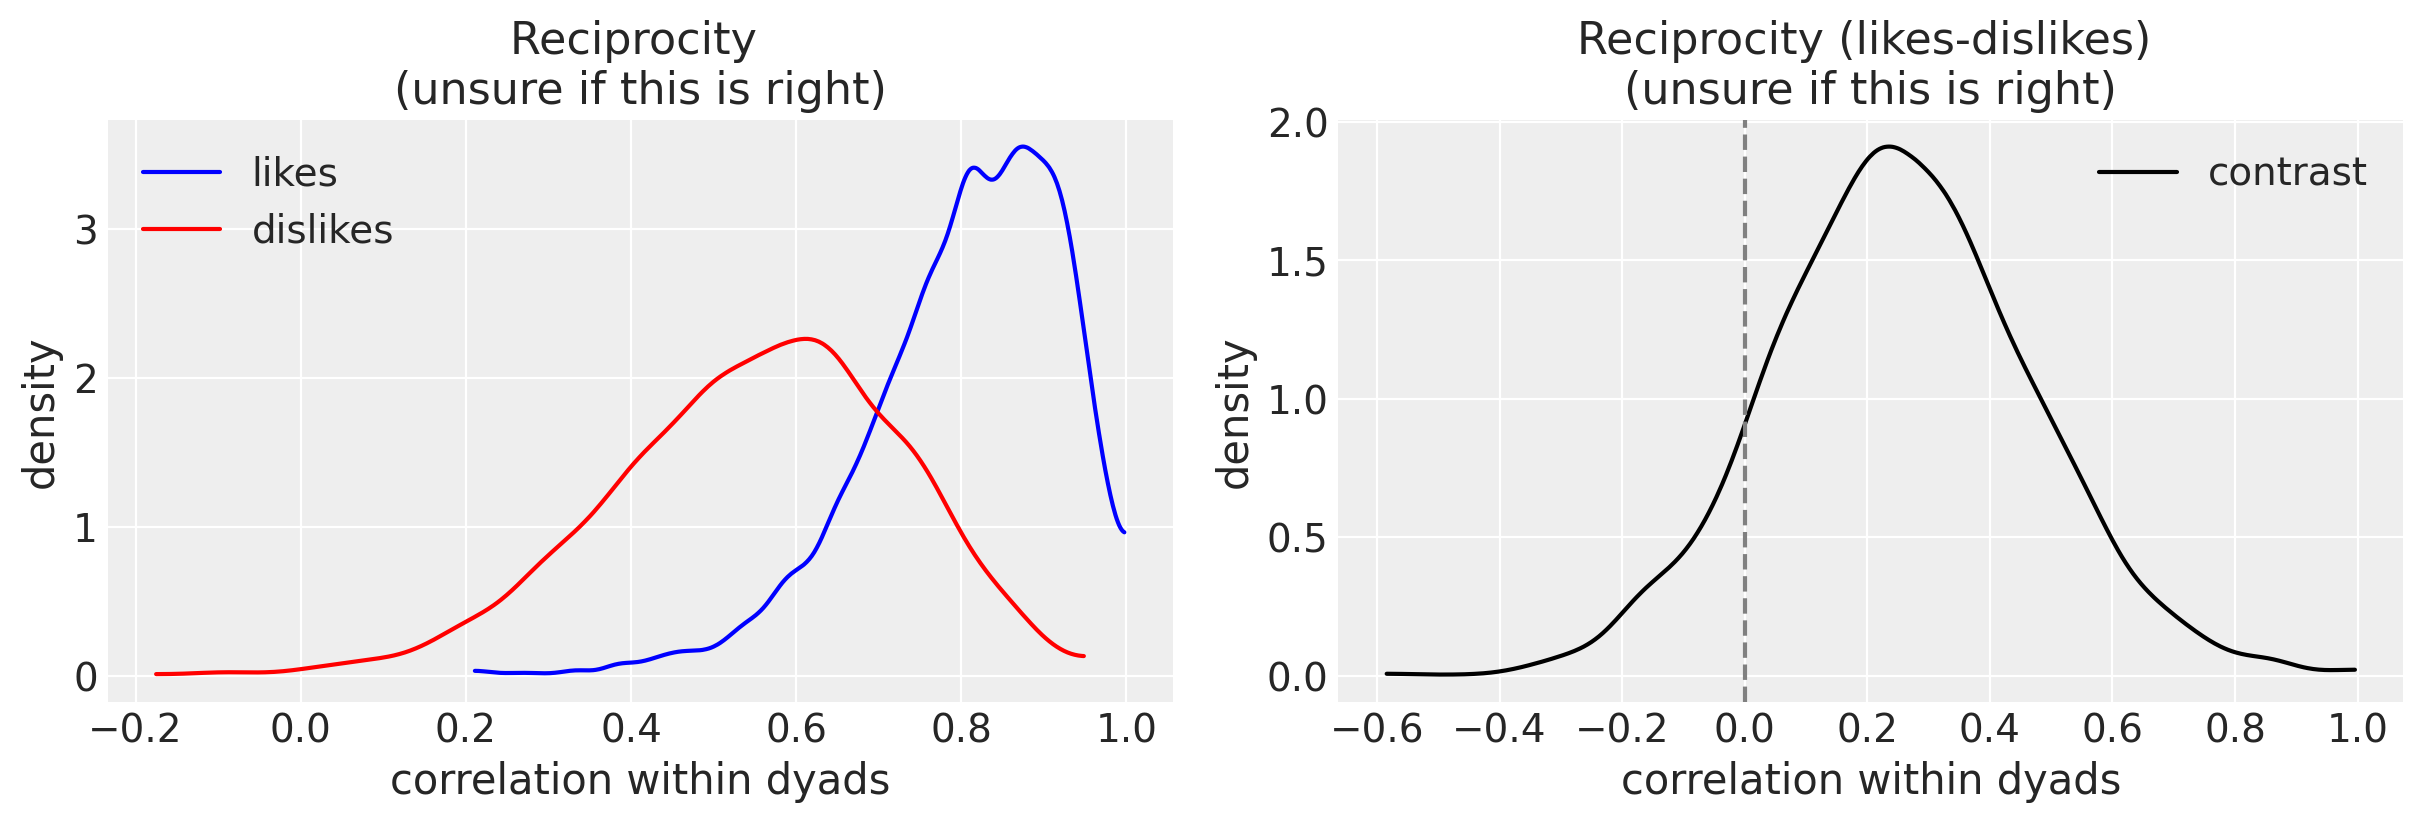

<IPython.core.display.Javascript object>

In [63]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_kde(trace_mq1a_df['chol_corr__0_1'], label='likes', plot_kwargs={"color": "blue"}, ax=ax0)
az.plot_kde(trace_mq2a_df['chol_corr__0_1'], label='dislikes', plot_kwargs={"color": "red"}, ax=ax0)
ax0.legend()
ax0.set(xlabel='correlation within dyads', ylabel='density', title='Reciprocity \n(unsure if this is right)')

az.plot_kde(trace_mq1a_df['chol_corr__0_1']  - trace_mq2a_df['chol_corr__0_1'], label='contrast', plot_kwargs={"color": "black"}, ax=ax1)
ax1.set(xlabel='correlation within dyads', ylabel='density', title='Reciprocity (likes-dislikes) \n(unsure if this is right)')
ax1.axvline(x=0, color='gray', linestyle='--')

The raw data and posterior contrast indicate that reciprocity for likes is higher.

# Q3

Now consider generalized liking and disliking. Add generalized “receiving” parameters
to the model, analogous to receiving varying effects from the sharing example
in the book/lecture. (Each monk only named 3 likes and 3 dislikes each time,
so the amount of “giving” is fixed by design in these data.) Can you identify any
individuals who are particularly liked/disliked, independent of the dyadic relations?

## Answer

Let's remind ourselves of what a DAG should look like.


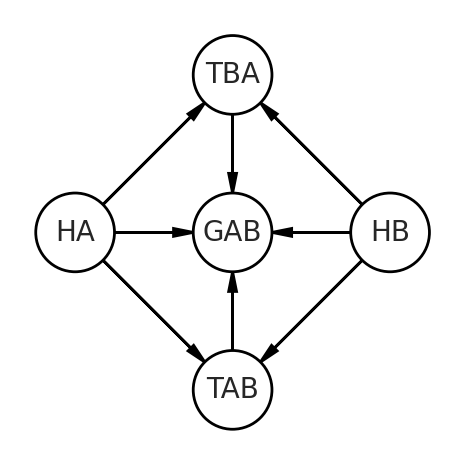

<IPython.core.display.Javascript object>

In [65]:
dag = CausalGraphicalModel(
    nodes=["HA", "TBA", "GAB", "TAB", "HB"],
    edges=[
        ("HA", "GAB"),
        ("HA", "TAB"),
        ("HA", "TBA"),
        ("TBA", "GAB"),
        ("TAB", "GAB"),
        ("HB", "GAB"),
        ("HB", "TAB"),
        ("HB", "TBA"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "HA": (-1, 0),
    "TBA": (0, 1),
    "GAB": (0, 0),
    "TAB": (0, -1),
    "HB": (1, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

In [69]:
hidA = dyads[0]
hidB = dyads[1]

<IPython.core.display.Javascript object>

In [70]:
with pm.Model() as mq3a:

    # dyad effects
    sd_dist = pm.Exponential.dist(1.0)
    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )
    z = pm.Normal("z", 0.0, 1.0, shape=(2, N_dyads))
    T = pm.Deterministic("T", pm.math.dot(chol, z).T)

    # generalized giving/receiving
    sd_dist1 = pm.Exponential.dist(1.0)
    # LKJCholeskyCov is more efficient than LKJCorr
    chol_gr, Rho_gr, sigma_gr = pm.LKJCholeskyCov(
        "chol_gr", n=2, eta=2, sd_dist=sd_dist1, compute_corr=True
    )
    z1 = pm.Normal("z1", 0.0, 1.0, shape=(2, N_dyads))
    gr = pm.Deterministic("gr", pm.math.dot(chol_gr, z).T)


    # linear models
    alpha = pm.Normal("alpha", 0, 1)
    lambdaAB = pm.Deterministic("lambdaAB", pm.math.exp(alpha + T[dyads.index, 0] + gr[hidA, 0] + gr[hidB, 1]))
    lambdaBA = pm.Deterministic("lambdaBA", pm.math.exp(alpha + T[dyads.index, 1] + gr[hidB, 0] + gr[hidA, 1]))

    DL_AB = pm.Poisson("DL_AB", mu = lambdaAB, observed = df_monks['dislike_AB'])
    DL_BA = pm.Poisson("DL_BA", mu = lambdaBA, observed = df_monks['dislike_BA'])

    trace_mq3a = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, z1, chol_gr, z, chol]
INFO:pymc3:NUTS: [alpha, z1, chol_gr, z, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some para

<IPython.core.display.Javascript object>

In [120]:
df_summary_gr = az.summary(trace_mq3a, var_names='gr')
df_summary_gr['gr_names'] = df_summary_gr.index.tolist()
df_summary_gr['did'] = df_summary_gr['gr_names'].str.split('[', expand=True)[1].str.split(',', expand=True)[0].astype('int')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<IPython.core.display.Javascript object>

In [112]:
g_ind = [i for i in df_summary_gr.index.tolist() if ',0]' in i]
r_ind = [i for i in df_summary_gr.index.tolist() if ',1]' in i]

<IPython.core.display.Javascript object>

In [122]:
df_summary_gr.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gr_names,did
"gr[0,0]",-0.202,0.329,-0.687,0.191,0.009,0.006,1494.0,1494.0,1910.0,2099.0,1.0,"gr[0,0]",0
"gr[0,1]",0.015,0.657,-0.965,1.105,0.013,0.010,2586.0,2075.0,2617.0,2981.0,1.0,"gr[0,1]",0
"gr[1,0]",-0.305,0.496,-0.946,0.223,0.019,0.013,709.0,709.0,770.0,1323.0,1.0,"gr[1,0]",1
"gr[1,1]",-1.647,1.209,-3.421,0.232,0.029,0.022,1691.0,1529.0,1850.0,2369.0,1.0,"gr[1,1]",1
"gr[2,0]",-0.123,0.288,-0.567,0.243,0.008,0.006,1328.0,1222.0,1417.0,1782.0,1.0,"gr[2,0]",2


<IPython.core.display.Javascript object>

In [127]:
df_summary_gr_wid = pd.merge(
        df_summary_gr,
        df_monks[['A_name', 'B_name', 'A_code', 'B_code']],
        left_on='did',
        right_index=True
    )


<IPython.core.display.Javascript object>

In [128]:
df_summary_gr_wid.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gr_names,did,A_name,B_name,A_code,B_code
"gr[0,0]",-0.202,0.329,-0.687,0.191,0.009,0.006,1494.0,1494.0,1910.0,2099.0,1.0,"gr[0,0]",0,ROMUL,BONAVEN,0,0
"gr[0,1]",0.015,0.657,-0.965,1.105,0.013,0.010,2586.0,2075.0,2617.0,2981.0,1.0,"gr[0,1]",0,ROMUL,BONAVEN,0,0
"gr[1,0]",-0.305,0.496,-0.946,0.223,0.019,0.013,709.0,709.0,770.0,1323.0,1.0,"gr[1,0]",1,ROMUL,AMBROSE,0,1
"gr[1,1]",-1.647,1.209,-3.421,0.232,0.029,0.022,1691.0,1529.0,1850.0,2369.0,1.0,"gr[1,1]",1,ROMUL,AMBROSE,0,1
"gr[2,0]",-0.123,0.288,-0.567,0.243,0.008,0.006,1328.0,1222.0,1417.0,1782.0,1.0,"gr[2,0]",2,ROMUL,BERTH,0,2


<IPython.core.display.Javascript object>

In [129]:
# Those that give
df_summary_gr_wid.loc[g_ind, :].sort_values(by='mean', ascending=False)[['mean', 'A_name', 'A_code']]

,mean,A_name,A_code
"gr[134,0]",0.500,BONI,11
"gr[111,0]",0.458,JOHN,8
"gr[56,0]",0.400,BERTH,3
"gr[59,0]",0.358,BERTH,3
"gr[45,0]",0.351,AMBROSE,2
...,...,...,...
"gr[5,0]",-0.169,ROMUL,0
"gr[48,0]",-0.180,BERTH,3
"gr[7,0]",-0.192,ROMUL,0
"gr[0,0]",-0.202,ROMUL,0


<IPython.core.display.Javascript object>

In [131]:
# Those that receive
df_summary_gr_wid.loc[r_ind, :].sort_values(by='mean', ascending=False)[['mean', 'B_name', 'B_code']]

,mean,B_name,B_code
"gr[4,1]",1.550,LOUIS,4
"gr[60,1]",1.433,ELIAS,15
"gr[97,1]",1.408,SIMP,16
"gr[9,1]",1.262,HUGH,9
"gr[121,1]",1.124,AMAND,13
...,...,...,...
"gr[17,1]",-1.126,AMBROSE,1
"gr[2,1]",-1.639,BERTH,2
"gr[1,1]",-1.647,AMBROSE,1
"gr[5,1]",-1.674,VICTOR,5


<IPython.core.display.Javascript object>

# Q4 (optional)

xxxxx

## Answer

yyyyyyy

### Replicating lecture 6 example

Using lecture 6, slide 83 example. R code shown below

```
f <- function(n=100,bZX=1,bXY=1) {
Z <- rnorm(n)
X <- rnorm(n, bZX*Z )
Y <- rnorm(n, bXY*X )
bX <- coef( lm(Y ~ X) )['X']
bXZ <- coef( lm(Y ~ X + Z) )['X']
return( c(bX,bXZ) )
}
sim <- mcreplicate( 1e4 , f(n=50) , mc.cores=8 )
dens( sim[1,] , lwd=3 , xlab="posterior mean" )
dens( sim[2,] , lwd=3 , col=2 , add=TRUE )

```

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>